In [1]:
!pip install -U git+https://github.com/d2l-ai/d2l-en.git@master

  Cloning https://github.com/d2l-ai/d2l-en.git (to revision master) to /tmp/pip-req-build-hffd6u15
  Running command git clone -q https://github.com/d2l-ai/d2l-en.git /tmp/pip-req-build-hffd6u15
  Created wheel for d2l: filename=d2l-0.15.1-cp36-none-any.whl size=72391 sha256=d16bcf201e73461755c6e692e028b931db2a52694589f0d806217f194c71c27f
  Stored in directory: /tmp/pip-ephem-wheel-cache-b1l2m34_/wheels/0f/41/8f/72ece70ede8a0e37eec72c03087eb4604925ba212b804f8cad
Successfully built d2l


In [2]:
%matplotlib inline
from d2l import torch as d2l
import torch
import torchvision
import os
import pandas as pd

#@save
d2l.DATA_HUB['banana-detection'] = (d2l.DATA_URL + 'banana-detection.zip',
                           '5de26c8fce5ccdea9f91267273464dc968d20d72')

In [3]:
#@save
def read_data_bananas(is_train=True):
    """Read the bananas dataset images and labels."""
    data_dir = d2l.download_extract('banana-detection')
    csv_fname = os.path.join(data_dir, 'bananas_train' if is_train
                                    else 'bananas_val', 'label.csv')
    csv_data = pd.read_csv(csv_fname)
    csv_data = csv_data.set_index('img_name')
    images, targets = [], []
    for img_name, target in csv_data.iterrows():
        images.append(torchvision.io.read_image(
            os.path.join(data_dir, 'bananas_train' if is_train else
                         'bananas_val', 'images', f'{img_name}')))
        # Since all images have same object class i.e. category '0',
        # the `label` column corresponds to the only object i.e. banana
        # The target is as follows : (`label`, `xmin`, `ymin`, `xmax`, `ymax`)
        targets.append(list(target))
    return images, torch.tensor(targets).unsqueeze(1) / 256


#@save
class BananasDataset(torch.utils.data.Dataset):
    def __init__(self, is_train):
        self.features, self.labels = read_data_bananas(is_train)
        print('read ' + str(len(self.features)) + (f' training examples' if
              is_train else f' validation examples'))

    def __getitem__(self, idx):
        return (self.features[idx].float(), self.labels[idx])

    def __len__(self):
        return len(self.features)


#@save
def load_data_bananas(batch_size):
    """Load the bananas dataset."""
    train_iter = torch.utils.data.DataLoader(BananasDataset(is_train=True),
                                             batch_size, shuffle=True)
    val_iter = torch.utils.data.DataLoader(BananasDataset(is_train=False),
                                           batch_size)
    return (train_iter, val_iter)

In [4]:
batch_size, edge_size = 32, 256
train_iter, _ = load_data_bananas(batch_size)
batch = next(iter(train_iter))
batch[0].shape, batch[1].shape

read 1000 training examples
read 100 validation examples


(torch.Size([32, 3, 256, 256]), torch.Size([32, 1, 5]))

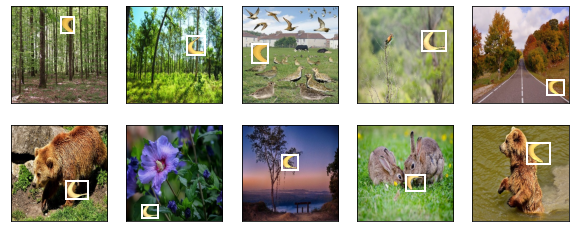

In [5]:
imgs = (batch[0][0:10].permute(0, 2, 3, 1)) / 255
axes = d2l.show_images(imgs, 2, 5, scale=2)
for ax, label in zip(axes, batch[1][0:10]):
    d2l.show_bboxes(ax, [label[0][1:5] * edge_size], colors=['w'])